# EDA 

Nesta primeira parte vamos buscar padrões nos dados e ver como eles caracterizam e explicam a rotatividade de clientes.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union

## 1 - Leitura dos dados

In [2]:
df = pd.read_csv("../data/raw/customer_churn_data - customer_churn_data.csv",decimal=",")
print("DataFrame shape: ",df.shape)
df.head()

DataFrame shape:  (7043, 22)


,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,...,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn
0,1,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,"R$ 29,85","R$ 29,85",Não
1,2,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,...,Pouco uso,Pouco uso,Pouco uso,Trimestral,0,No,Boleto - mês a mês,"R$ 56,95","R$ 1.889,50",Não
2,3,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,...,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - mês a mês,"R$ 53,85","R$ 108,15",Sim
3,4,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,...,Uso frequente,Pouco uso,Pouco uso,Trimestral,0,No,Cartão de crédito - pagamento único,"R$ 42,30","R$ 1.840,75",Não
4,5,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,"R$ 70,70","R$ 151,65",Sim


## 2 - Verificando qualidade dos dados

In [3]:
# Check dtypes 
df.dtypes

ID                                                                                   int64
Tipo de empresa                                                                     object
Fundação da empresa                                                                  int64
Possui mais de um sócio                                                             object
Funcionários                                                                        object
Meses de permanência                                                                 int64
Utiliza serviços financeiros                                                        object
PossuiContador                                                                      object
Faz conciliação bancária                                                            object
Frequência de utilização de feature do sistema: Módulo financeiro                   object
Frequência de utilização de feature do sistema: Emissão de nota fiscal              object

In [4]:
# Check for null values
(df.isnull().sum()/df.shape[0])*100.0

ID                                                                                  0.000000
Tipo de empresa                                                                     0.000000
Fundação da empresa                                                                 0.000000
Possui mais de um sócio                                                             0.000000
Funcionários                                                                        0.000000
Meses de permanência                                                                0.000000
Utiliza serviços financeiros                                                        0.000000
PossuiContador                                                                      9.683374
Faz conciliação bancária                                                            0.000000
Frequência de utilização de feature do sistema: Módulo financeiro                   0.000000
Frequência de utilização de feature do sistema: Emissão de nota fiscal

In [5]:
# Check for duplicated values
df[df.duplicated()]

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,...,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn


In [6]:
# For sanity check let's see is the values in Emite boletos.1 is equal to Emite boletos
col_emite_bol_bool = df["Emite boletos.1"].map({"Yes":1,"No":0})
col_emite_bol_bool.eq(df["Emite boletos"]).all()

True

Como podemos ver, este conjunto de dados contém muitos recursos categóricos. As únicas características numéricas são: `receita mensal` e `receita total` que vem como string, mas vamos configurar para float. Além disso, a variável `Emite boletos` é a mesma que `Emite boletos.1`, mas, como string, então, vamos descartar esta variável, pois ela não acrescenta nada para a análise.

In [7]:
def clear_numeric_strings(dataframe:pd.DataFrame,subset=Union[str,list]):
    new_df = dataframe.copy()
    if isinstance(subset,str):
        new_df[subset] = new_df[subset].str.replace(pat=r"([R$])|([.])",repl="",regex=True)\
                                               .str.strip()\
                                               .str.replace(pat=",",repl=".")
    else:
        new_df[subset] = new_df[subset].apply(
            func=lambda s: s.str.replace(pat=r"([R$])|([.])",repl="",regex=True)\
                                               .str.strip()\
                                               .str.replace(pat=",",repl="."),
            axis=1,
        )
    return new_df
        
def convert_to_numeric(dataframe:pd.DataFrame,subset:Union[str,list]):
    new_df = dataframe.copy()
    new_df[subset]=new_df[subset].astype("float")
    return new_df


conv_cols = ["Receita mensal","Receita total"]
df = clear_numeric_strings(dataframe=df,subset=conv_cols)
df = convert_to_numeric(dataframe=df,subset=conv_cols)
df = df.drop("Emite boletos",axis=1)
df.head()

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,...,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn
0,1,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,Yes,Boleto - pagamento único,29.85,29.85,Não
1,2,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,...,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Trimestral,No,Boleto - mês a mês,56.95,1889.50,Não
2,3,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,...,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,Yes,Boleto - mês a mês,53.85,108.15,Sim
3,4,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,...,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Trimestral,No,Cartão de crédito - pagamento único,42.30,1840.75,Não
4,5,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,Yes,Boleto - pagamento único,70.70,151.65,Sim


In [8]:
df.dtypes

ID                                                                                    int64
Tipo de empresa                                                                      object
Fundação da empresa                                                                   int64
Possui mais de um sócio                                                              object
Funcionários                                                                         object
Meses de permanência                                                                  int64
Utiliza serviços financeiros                                                         object
PossuiContador                                                                       object
Faz conciliação bancária                                                             object
Frequência de utilização de feature do sistema: Módulo financeiro                    object
Frequência de utilização de feature do sistema: Emissão de nota fiscal          

Como podemos ver, temos muitos valores categóricos, mas eles vêm como string e alguns como float. Para facilitar nossa análise vamos converter para categoria

In [9]:
def convert_to_categoric(dataframe:pd.DataFrame,subset:Union[str,list]):
    new_df = dataframe.copy()
    new_df[subset]=new_df[subset].astype("category")
    return new_df

cat_columns = list(df.select_dtypes(include="object",exclude=["float64","int64"]).columns)
df = convert_to_categoric(dataframe=df,subset=cat_columns)

In [10]:
df.dtypes

ID                                                                                     int64
Tipo de empresa                                                                     category
Fundação da empresa                                                                    int64
Possui mais de um sócio                                                             category
Funcionários                                                                        category
Meses de permanência                                                                   int64
Utiliza serviços financeiros                                                        category
PossuiContador                                                                      category
Faz conciliação bancária                                                            category
Frequência de utilização de feature do sistema: Módulo financeiro                   category
Frequência de utilização de feature do sistema: Emissão de nota fiscal

Vamos verificar a cardinalidade de das variáveis categóricas

In [11]:
cat_cols =df.select_dtypes(include="category",exclude=["int64"]) 
for col in cat_cols:
    print(f"{col} has {len(cat_cols[col].cat.categories)} variables: {list(cat_cols[col].cat.categories)}")

Tipo de empresa has 2 variables: ['Micro empresa', 'Pequena empresa']
Possui mais de um sócio has 2 variables: ['Não', 'Sim']
Funcionários has 2 variables: ['6 ou mais funcionários', 'até 5 funcionários']
Utiliza serviços financeiros has 2 variables: ['Não', 'Sim']
PossuiContador has 2 variables: ['Não ', 'Sim']
Faz conciliação bancária has 3 variables: ['automática', 'manual', 'não faz']
Frequência de utilização de feature do sistema: Módulo financeiro has 3 variables: ['Nunca utilizou', 'Pouco uso', 'Uso frequente']
Frequência de utilização de feature do sistema: Emissão de nota fiscal has 3 variables: ['Nunca utilizou', 'Pouco uso', 'Uso frequente']
Frequência de utilização de feature do sistema: Integração bancária has 3 variables: ['Nunca utilizou', 'Pouco uso', 'Uso frequente']
Frequência de utilização de feature do sistema: Módulo de vendas has 3 variables: ['Nunca utilizou', 'Pouco uso', 'Uso frequente']
Frequência de utilização de feature do sistema: Relatórios has 3 variables

A qualidade geral dos dados é boa! Temos pequenas quantidades de valores nulos e zero valores duplicados. Além disso, com a codificação podemos tratar os dados numéricos que vêm como string e ver que os valores categóricos possuem baixa cardinalidade. Para o resto da EDA, isto é suficiente. Vamos ver agora os padrões nos dados.

## 3 - Análise

Vamos separar as variáveis categóricas e numéricas

In [12]:
NUM_VARIABLES = list(df.select_dtypes(include=["int64","float64"]).drop(columns=["ID"],axis=1).columns)
CAT_VARIABLES = list(df.select_dtypes(include="category").columns)

### 3.1 Como as variáveis númericas afeta o churn?

/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

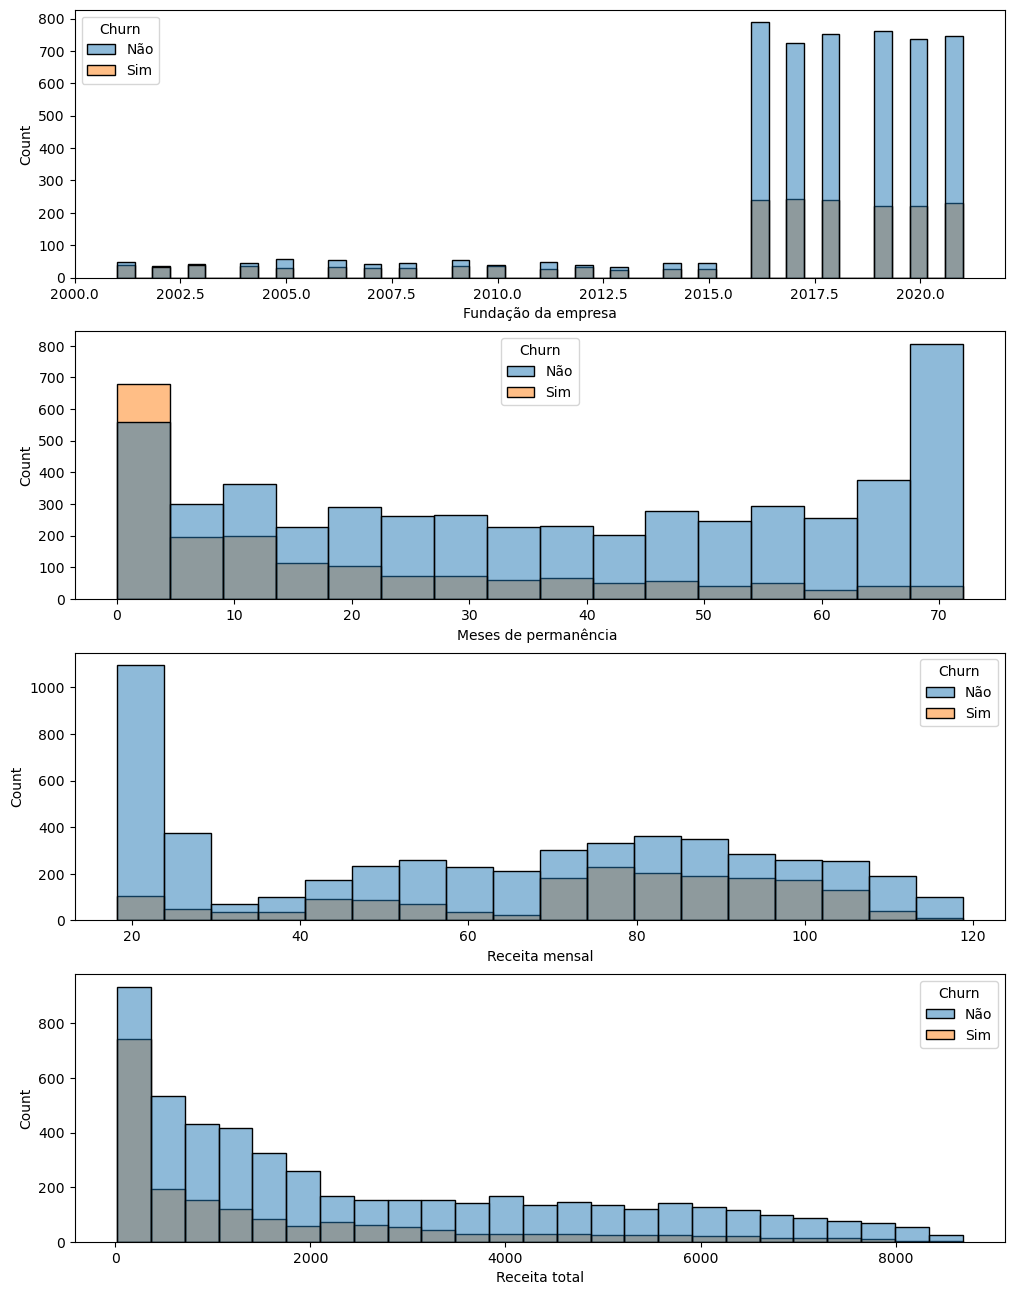

In [22]:
fig, axes = plt.subplots(len(NUM_VARIABLES),1,figsize=(12,16),gridspec_kw={"wspace":0.2,"hspace":0.2})
for col,ax in zip(NUM_VARIABLES,axes):
    sns.histplot(data=df,x=col,hue="Churn",ax=ax)

/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

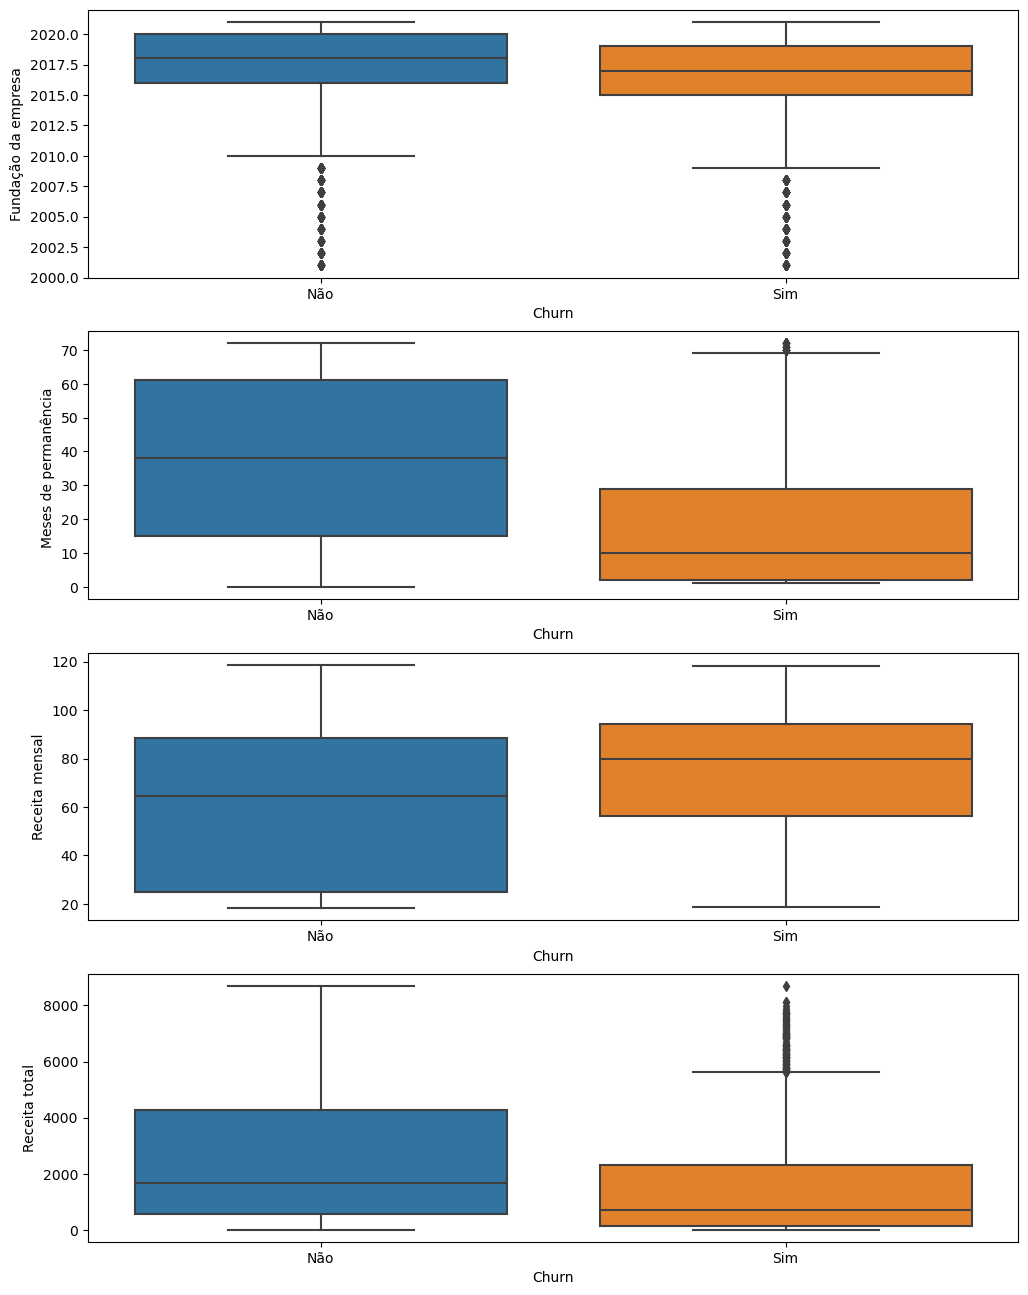

In [21]:
fig, axes = plt.subplots(len(NUM_VARIABLES),1,figsize=(12,16),gridspec_kw={"wspace":0.2,"hspace":0.2})
# for col,ax in zip(NUM_VARIABLES,axes):
#     sns.histplot(data=df,x=col,hue="Churn",ax=ax)
for col,ax in zip(NUM_VARIABLES,axes):
    sns.boxplot(data=df,y=col,x="Churn",ax=ax)

Por meio desses gráficos, podemos inferir que as empresas que realizam churn possuem menores meses de permanência e uma receita mensal elevada, mas menor receita total.

### 3.3 Como as variáveis categóricas afetam o churn?

/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

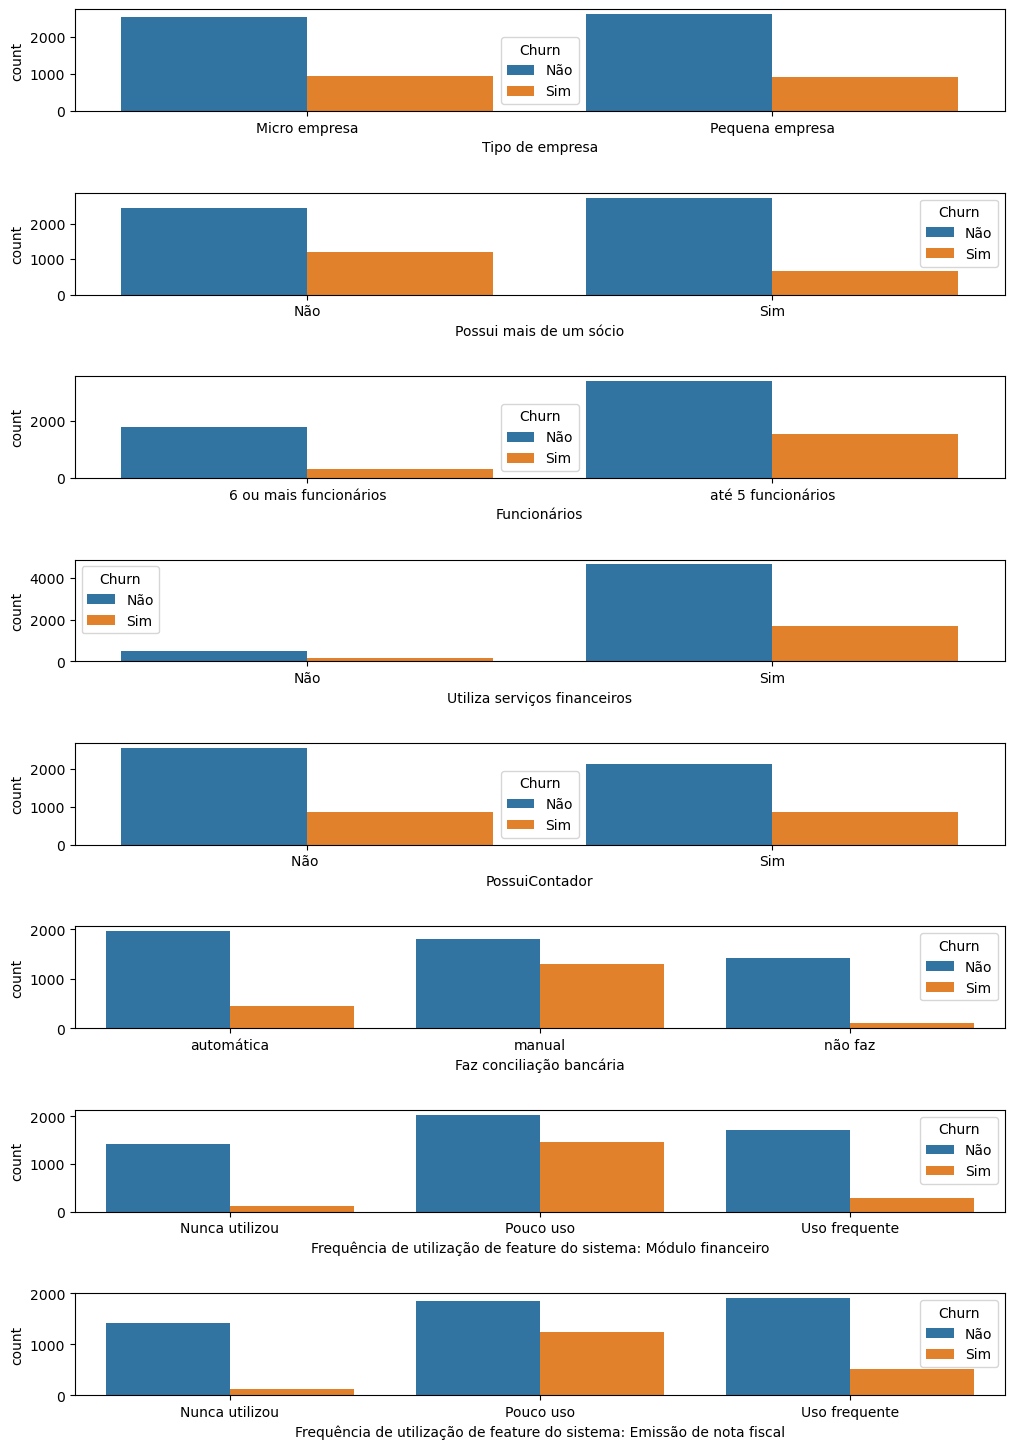

In [37]:
fig, axes = plt.subplots(len(CAT_VARIABLES[:8]),1,figsize=(12,18),gridspec_kw={"wspace":0.2,"hspace":0.8})
for col,ax in zip(CAT_VARIABLES[:8],axes):
    sns.countplot(data=df,x=col,hue="Churn",ax=ax)

Por esses gráficos, podemos inferir que Tipo de empresa e PossuiContador tem um efeito similar no Churn, elas afetam mas em proporção similar.
Já as outras variáveis têm impactos diferentes, especialmente as variáveis sobre o uso de recursos pelo usuário (Módulo financeiro e emissão de nota fiscal)

/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

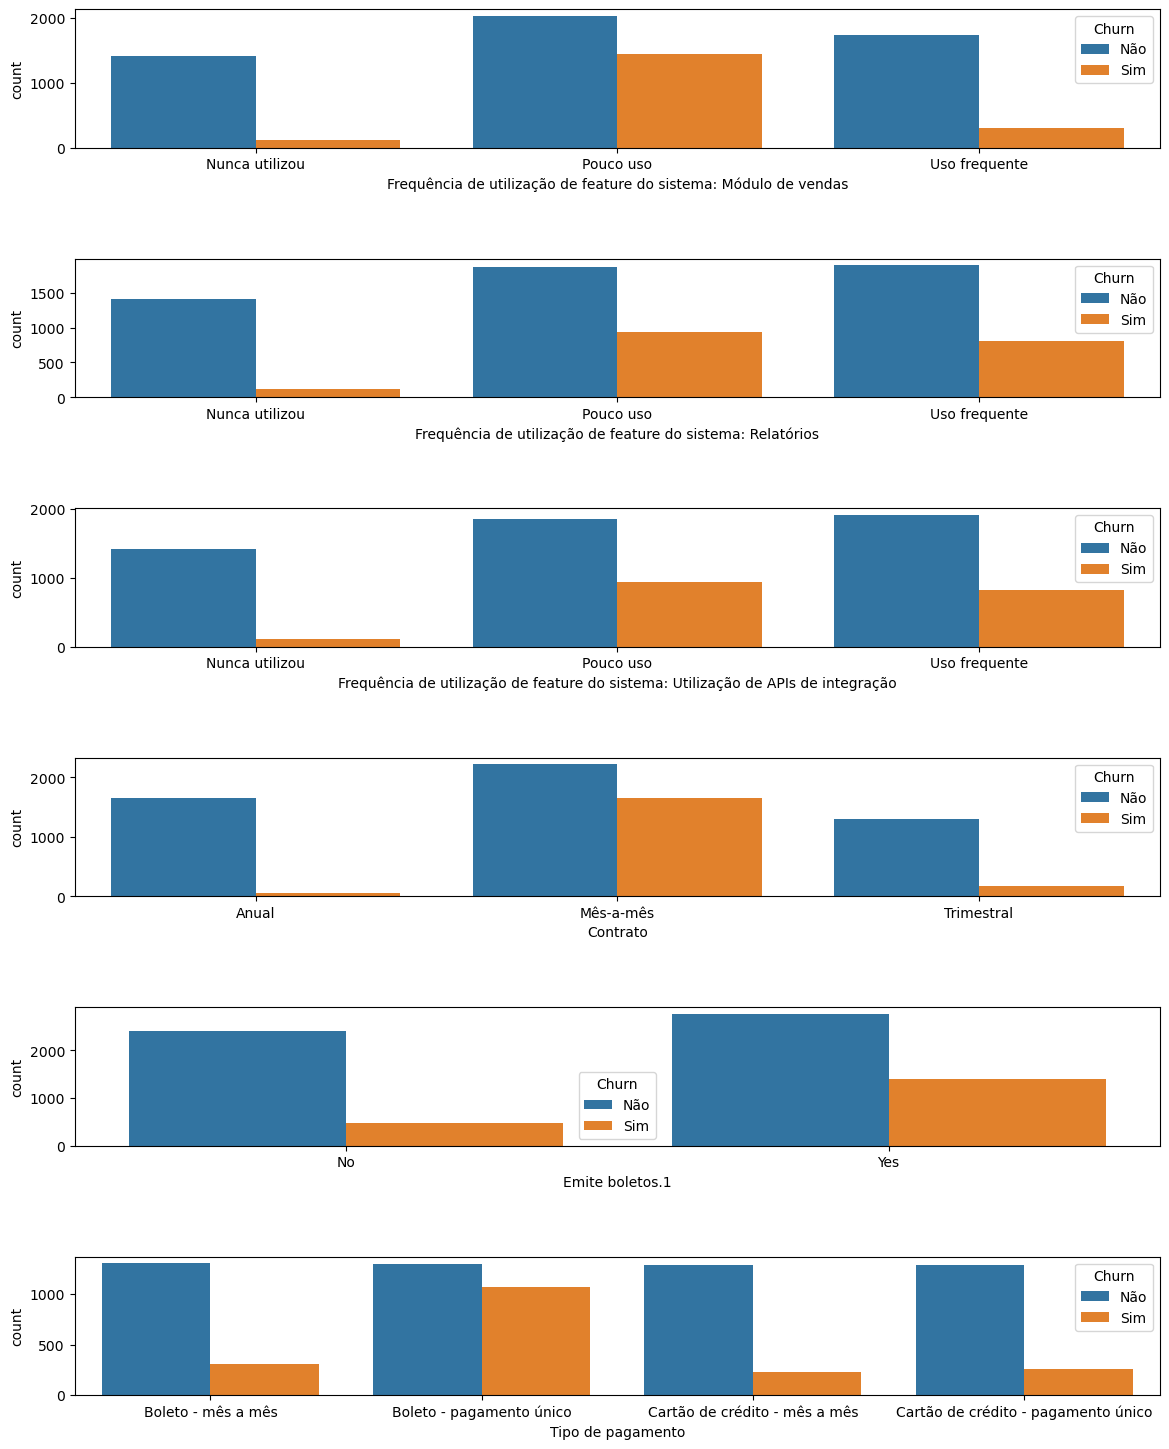

In [24]:
fig, axes = plt.subplots(len(CAT_VARIABLES[9:len(CAT_VARIABLES)-1]),1,figsize=(14,18),gridspec_kw={"wspace":0.2,"hspace":0.8})
for col,ax in zip(CAT_VARIABLES[9:len(CAT_VARIABLES)-1],axes):
    sns.countplot(data=df,x=col,hue="Churn",ax=ax)

Para essas variáveis, podemos perceber que a frequência de uso do usuário tem um impacto enorme. Além disso, "Tipo de pagamento", "Emitir boletos.1" e "Tipo de contrato" também têm impacto. Podemos dizer que para o churn as empresas não fazem grande uso da plataforma, além disso, o tamanho da empresa (quantos funcionários e clientes, se emitem boletos e como é a forma de pagamento) também impacta.

Finalmente, para este conjunto de dados podemos ver que as empresas que fizeram churn têm uma receita mais instável porque a sua receita mensal é maior do que as empresas que não fazem churn, mas a receita total é menor. Então essa é uma variável importante a ser monitorada pelas empresas.

## 4 - Conclusão

- Podemos ver que o número de churn é menor que o número de não churns (conjunto de dados desequilibrado)
- Temos muitos variáveis categóricos, mas eles têm cardinalidade baixa, o que ajudará na construção do modelo.
- As variáveis de receita são os únicos variáveis numéricas que temos mas para utilização no modelo é importante pensar em como trabalhar com elas.
